# Training workflow

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import copy

from IPython.display import Video

## Constants

In [2]:
CUDA = torch.cuda.is_available()
RANDOM_SEED = 9
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NUM_EPOCHS = 9

print(f"CUDA: {CUDA}")

CUDA: True


In [3]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Load Data

Extracted features, scores, metadata, etc.

In [4]:
data = pd.read_csv("training_set/scores.csv").set_index("video_id")

In [5]:
Video(data.iloc[22]["video_url"])

In [6]:
def load_C3D_features(video_ids, path ="training_set/Features/C3D/"):
    features = []
    for video_id in video_ids:
        filename = f"{path}{f'{video_id}'.zfill(5)}.mp4.csv"
        features.append(np.loadtxt(filename, delimiter=","))
    return features

In [7]:
data["c3d"] = load_C3D_features(data.index)

## Target Prep

Khosla points out that the memorability score used in Isola's paper did not take into account the memory retention duration.
Cohendet utilized the same idea as Khosla, which involved a decay rate

$$\alpha \leftarrow 
\frac{\sum^N_{i=1}\frac{1}{n^{(i)}} \sum^{n^{(i)}}_{j=1} \log(\frac{t^{(i)}_j}{T})[x^{(i)}_j - m^{(i)}_T] }
{\sum^N_{i=1}\frac{1}{n^{(i)}} \sum^{n^{(i)}}_{j=1}[ \log(\frac{t^{(i)}_j}{T})]^2}
$$

to calculate memorability 
$$
m_T^{(i)} \leftarrow
\frac{1}{n^{(i)}} \sum^{n^{(i)}}_{j=1}[x^{(i)}_j - \alpha \log(\frac{t_j^{(i)}}{T})]
$$

where we have $n^{(i)}$ observations for image $i$ given by $x^{(i)} \in {0,1}$ and $t^{(i)}_j$ where $x_j=1$  implies that the image repeat was correctly detected when it shown after time $t_j$

IDEA: potentially explore calculating $\alpha$ per user

In [8]:
st_annotations = pd.read_csv("training_set/short_term_annotations.csv")

In [9]:
st_annotations["t"] = st_annotations["video_position_second"] - st_annotations["video_position_first"]
st_annotations.head()

,video_id,video_url,user_id,rt,key_press,video_position_first,video_position_second,correct,t
0,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,129,1958,32,59,147,1,88
1,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,212,1077,32,32,101,1,69
2,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,335,1067,32,70,120,1,50
3,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,439,2265,32,55,106,1,51
4,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,505,1520,32,67,135,1,68


In [10]:
print("Average t:", np.mean(st_annotations["t"]))

Average t: 74.81127450980392


In [11]:
# We use approximately the average_t to calculate T as the memorability in question
big_t = 75

In [12]:
def calculate_alpha(annotations, m_T, T = 75):
    numerator = 0
    denominator = 0
    for video_id, video in annotations.groupby("video_id"):
        t = video["t"].to_numpy()
        x = video["correct"].to_numpy()
        n = len(video)
        m = m_T[video_id]
        for j in range(n):
            numerator += (np.log(t[j] / T) * (x[j] - m)) / n
            denominator += (np.log(t[j] / T) ** 2) / n

    return numerator / denominator

In [13]:
def calculate_memorability(annotations, alpha, T = 75):
    m_T = {}
    for video_id, video in annotations.groupby("video_id"):
        t = video["t"].to_numpy()
        x = video["correct"].to_numpy()
        n = len(video)
        m = 0
        for j in range(n):
            m += x[j] - (alpha * np.log(t[j] / T))
        m_T[video_id] = m / n
    return m_T

In [14]:
num_iterations = 10

m_T = {video_id: 1 for video_id in st_annotations["video_id"]}
for iteration in range(num_iterations):
    alpha = calculate_alpha(st_annotations, m_T, T = big_t)
    m_T = calculate_memorability(st_annotations, alpha, T = big_t)
print(alpha)

-0.00027284180298008494


In [15]:
data[f"m_{big_t}"] = pd.Series(m_T)

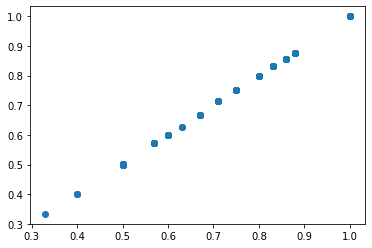

In [16]:
plt.scatter(data["part_1_scores"], data[f"m_{big_t}"])
plt.show()

## Data Prep

Building datasets

potentially weighting samples based on annotations?



In [17]:
data.head()

,video_url,ann_1,ann_2,part_1_scores,part_2_scores,c3d,m_75
video_id,,,,,,,
8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,5,3,1.00,1.00,"[0.0, 0.0, 0.0, 0.0, 0.1541, 0.3501, 0.1796, 0...",0.999956
26,https://mtc.cdn.vine.co/r/videos_h264high/A8B3...,6,4,1.00,0.75,"[0.6788, 0.2429, 0.0, 0.0, 0.8737, 0.0, 0.0, 0...",1.000011
33,https://mtc.cdn.vine.co/r/videos/267829AEFA128...,7,4,0.71,0.75,"[0.511, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.714208
46,https://mtc.cdn.vine.co/r/videos_h264high/B974...,6,4,1.00,0.25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.363...",0.999949
64,https://mtc.cdn.vine.co/r/videos_h264high/C4D6...,6,7,0.83,0.43,"[0.4755, 0.0, 0.0153, 0.0, 0.0, 0.1077, 0.0, 0...",0.833345


In [18]:
np.min(data["m_75"] - data["part_1_scores"])

-0.005042831159032035

In [19]:
def split_training(data: pd.DataFrame, shuffle=True, split=0.8):
    ids = np.random.permutation(list(data.index)) if shuffle else list(data.index)
    split_index = int(len(ids) * split)
    return data.loc[ids[:split_index]], data.loc[ids[split_index:]]

In [20]:
train, valid = split_training(data)
print("training:",len(train))
print("validation:", len(valid))

training: 472
validation: 118


In [21]:
def build_matrixes(data: pd.DataFrame, targets, features, dtype="double"):
    feature_matrix = [np.concatenate(list(row_features), axis=None) 
                      for row_features in zip(*[list(data[feature]) for feature in features])]
    target_matrix = list(data[target])
    return np.array(feature_matrix, dtype=dtype), np.array(target_matrix, dtype=dtype).reshape((len(target_matrix),1))

In [22]:
target = "m_75"
features = ["c3d"]

features_train, targets_train = build_matrixes(train, targets = target, features = features)
features_valid, targets_valid = build_matrixes(valid, targets = target, features = features)

print("features_train shape:", features_train.shape)
print("targets_train shape:", targets_train.shape)
print("features_valid shape:", features_valid.shape)
print("features_valid shape:", targets_valid.shape)

features_train shape: (472, 4096)
targets_train shape: (472, 1)
features_valid shape: (118, 4096)
features_valid shape: (118, 1)


In [23]:
class FlatDataset(torch.utils.data.Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [24]:
data_train = FlatDataset(features_train, targets_train)
data_valid = FlatDataset(features_valid, targets_valid)
print(len(data_train), len(data_valid))

472 118


## Model setup

In [25]:
input_dim = len(features_train[0])
output_dim = 1 if len(targets_train.shape) == 1 else len(targets_train[0])
print("input dimensions:", input_dim)
print("output dimension:", output_dim)

input dimensions: 4096
output dimension: 1


In [26]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim = 100):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.tanh = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        return x
        

In [27]:
model = TwoLayerNet(input_dim, output_dim)
model

TwoLayerNet(
  (linear1): Linear(in_features=4096, out_features=100, bias=True)
  (tanh): Tanh()
  (linear2): Linear(in_features=100, out_features=1, bias=True)
)

## Training setup

In [28]:
device = torch.device("cuda") if CUDA else torch.device("cpu")
model = model.double().to(device)

In [29]:
num_epochs = NUM_EPOCHS

In [30]:
batch_size = BATCH_SIZE

In [31]:
learning_rate = LEARNING_RATE

In [32]:
loss_fn = torch.nn.MSELoss()

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [34]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma = 0.5)

In [35]:
dataloader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(data_valid, batch_size=1)

## Train model

In [36]:
def train(model, dataloader_train, dataloader_valid, loss_fn, optimizer, scheduler, device):
    
    for is_training in [True, False]: # Epoch is a training followed by validation 
        
        model.train() if is_training else model.eval()
        
        running_loss = 0
        for features, targets in (dataloader_train if is_training else dataloader_valid):
            features = features.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(is_training):
                outputs = model(features)
                loss = loss_fn(outputs, targets)
                if is_training:
                    loss.backward()
                    optimizer.step()               
            running_loss += loss.item()
        
        if is_training:
            scheduler.step()
        
        if is_training:
            train_loss = running_loss / len(dataloader_train.dataset)
        else:
            valid_loss = running_loss / len(dataloader_valid.dataset)
    
    return train_loss, valid_loss

In [37]:
best_valid_loss = 9999999
best_model_state_dict = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    print(f"--------------- Epoch {epoch} ----------------")
    train_loss, val_loss = train(model = model,
                                 dataloader_train = dataloader_train,
                                 dataloader_valid = dataloader_valid,
                                 loss_fn = loss_fn,
                                 optimizer = optimizer,
                                 scheduler = scheduler,
                                 device = device)
    
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        best_model_state_dict = copy.deepcopy(model.state_dict())
        print("New Best Validiation Loss!!!", val_loss)
    
    print("Training Loss:", train_loss)
    print("Validation Loss:", val_loss)
print("\n\nFINISHED TRAINING")
print(f"Best validation lost: {best_valid_loss}")

--------------- Epoch 0 ----------------
New Best Validiation Loss!!! 1.396046364529529
Training Loss: 0.024960063724014898
Validation Loss: 1.396046364529529
--------------- Epoch 1 ----------------
New Best Validiation Loss!!! 0.12950837790190795
Training Loss: 0.010428656212696214
Validation Loss: 0.12950837790190795
--------------- Epoch 2 ----------------
Training Loss: 0.002876708570364191
Validation Loss: 0.3573786912400251
--------------- Epoch 3 ----------------
New Best Validiation Loss!!! 0.08564403141345557
Training Loss: 0.002052671127994823
Validation Loss: 0.08564403141345557
--------------- Epoch 4 ----------------
New Best Validiation Loss!!! 0.02142584928000933
Training Loss: 0.00036043141844714193
Validation Loss: 0.02142584928000933
--------------- Epoch 5 ----------------
Training Loss: 0.000258540003152863
Validation Loss: 0.05027600829675583
--------------- Epoch 6 ----------------
Training Loss: 0.00045401714405019205
Validation Loss: 0.053759412688382635
------

In [38]:
best_model = model
best_model = best_model.eval()
best_model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

## Test

Spearman's rank correlation, ROC curves, etc

In [39]:
predictions = []
actuals = []
for feature, actual in dataloader_valid:
    with torch.set_grad_enabled(False):
        feature = feature.to(device)
        output = best_model(feature)
        predictions.append(output.cpu().numpy()[0][0])
        actuals.append(actual.cpu().numpy()[0][0])

In [40]:
spearman_rank, _ = stats.spearmanr(actuals, predictions)
print(spearman_rank)

0.1797793432888149


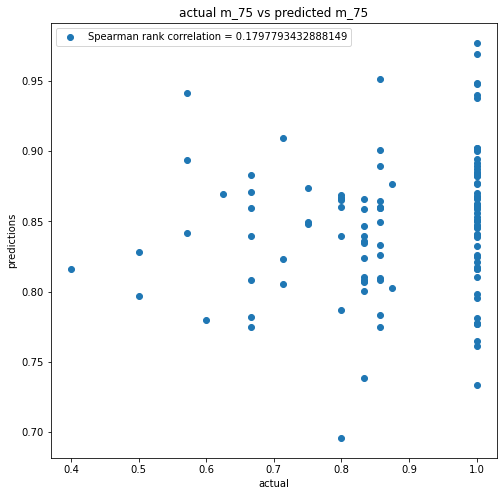

In [41]:
fig, ax = plt.subplots(1, figsize=(8,8))
plt.scatter(actuals, predictions, label = f"Spearman rank correlation = {spearman_rank}")
plt.title(f"actual {target} vs predicted {target}")
plt.legend()
plt.ylabel("predictions")
plt.xlabel("actual")
plt.show()

# Saving model to file

In [42]:
modelname = "c3d"

In [43]:
if not os.path.exists(f"saved_models/{modelname}"):
    os.mkdir(f"saved_models/{modelname}")

if not np.sum([spearman_rank < float(f"0.{s.split('.')[0]}") for s in os.listdir(f"saved_models/{modelname}")]):
    filename = f"saved_models/{modelname}/{str(spearman_rank)[2:6]}.state_dict"
    torch.save(best_model.state_dict(), filename)
    print(f"Model saved as {filename}")